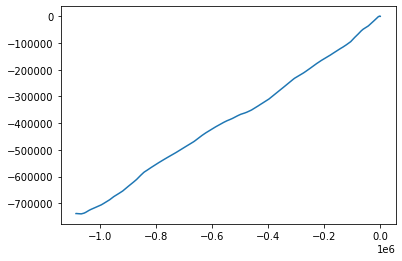

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math
t = 1
fi = open( "IMU_output1.txt", 'r' ) #input file name
x = 0
y = 0
ux = 0
uy = 0
ang = 0
trajectory_x = []
trajectory_y = []
for line in fi:
    words = line.split( '),' )
    words_a = words[ 12 ]
    words_a = words_a.split( '(' )
    words_a = words_a[ 1 ]
    acc = words_a.split( ',' )
    acc_x = float( acc[ 0 ] )
    acc_y = float( acc[ 1 ] )   
    ax = acc_x * math.cos( math.pi * ang / 180 ) - acc_y * math.sin( math.pi * ang / 180 )
    ay = acc_y * math.cos( math.pi * ang / 180 ) + acc_x * math.sin( math.pi * ang / 180 )
    x = x + ux * t + ax * ( t ** 2 ) / 2
    y = y + uy * t + ay * ( t ** 2 ) / 2
    ux = ux + ax * t
    uy = uy + ay * t
    words_aa = words[ 10 ]
    words_aa = words_aa.split( '(' )
    words_aa = words_aa[ 1 ]
    wa = words_aa.split( ',' )
    wa_z = float( wa[ 2 ] )
    ang = ang + wa_z * t 
    trajectory_x.append( x )
    trajectory_y.append( y ) 
    
    
    
fi.close()
plt.plot( trajectory_x, trajectory_y )
plt.show() 

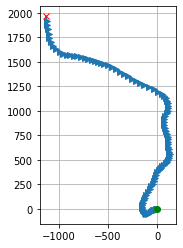

Difference between the initial and final position =  2270.428364
Estimated total travelled distance =  3035.996244


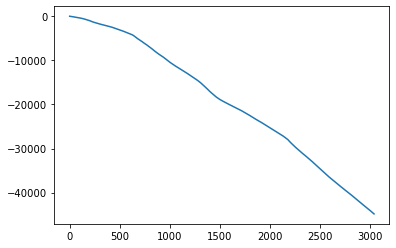

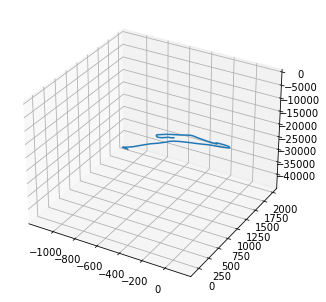

In [6]:
import matplotlib.animation as animation
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.pyplot as plt
#%matplotlib inline
import numpy as np
from scipy import linalg as lin
import pandas as pd

# Read data from file.
#samplePeriod = np.around(1/Fs, decimals=4) 
file = open( "IMU_output1.txt", 'r' ) #input file name
# filePath = '~/datasets/conf-3333-coleta04-02-06-21-5ds_03.csv' #YOU NEED TO VERIFY THIS LINE
#data = pd.read_csv(filePath, header = None, sep = ',', names=['mpu_id', 'ts', 'q.w', 'q.x', 'q.y', 'q.z', 'ax', 'ay', 'az', 'gx', 'gy', 'gz'])
# data = pd.read_csv(filePath, header = None, sep = ',', names=['t', 'ax1', 'ay1', 'az1', 'gx1', 'gy1', 'gz1', 'ax2', 'ay2', 'az2', 'gx2', 'gy2', 'gz2'])

# datasize = len(data.iloc[:, 0].values) # data_size = length(data.data)
#timestamp = (data.iloc[:,1].values).T # Timestamps of measurements.
#timestamp = (np.arange(0, datasize, 1/100)).T
g = 9.81 #Gravity 

# Accelerations is in sensor frame.
# Rates of turn is in sensor frame.

acc_scale_range = 3 # 0 for 2g, 1 for 4g, 2 for 8g and 3 for 16g
gyro_scale_range = 3 # 0 for 250, 1 for 500, 2 for 1000 and 3 for 2000
sensor = 1

if(acc_scale_range==0):
    acc_factor = 16384
elif(acc_scale_range==1):
    acc_factor = 8192
elif(acc_scale_range==2):
    acc_factor = 4096
elif(acc_scale_range==3):
    acc_factor = 0.5 #2048

if(gyro_scale_range==0):
    gyro_factor = 131
elif(gyro_scale_range==1):
    gyro_factor = 65.5
elif(gyro_scale_range==2):
    gyro_factor = 32.8
elif(gyro_scale_range==3):
    gyro_factor = 0.5 #16.4
accl = []
gyro = []
size = 0
for line in file:
    words = line.split( '),' )
    words_a = words[ 12 ]
    words_a = words_a.split( '(' )
    words_a = words_a[ 1 ]
    acc = words_a.split( ',' )
    acc_x = float( acc[ 0 ] ) / acc_factor *g
    acc_y = float( acc[ 1 ] ) / acc_factor *g  
    acc_z = float( acc[ 2 ] ) / acc_factor *g
    a = [ acc_x, acc_y, acc_z ] 
    accl.append( a )
    words_aa = words[ 10 ]
    words_aa = words_aa.split( '(' )
    words_aa = words_aa[ 1 ]
    wa = words_aa.split( ',' )
    wa_z = np.deg2rad( float( wa[ 2 ] ) / gyro_factor )
    wa_x = np.deg2rad( float( wa[ 0 ] ) / gyro_factor )
    wa_y = np.deg2rad( float( wa[ 1 ] ) / gyro_factor )
    w = [ wa_x, wa_y, wa_z ] 
    gyro.append( w )  
    size += 1
# print( size )  
# print( gyro )
# print(len( accl[ 0 ] ))
acc_s = np.array( [ [ 0 for i in range( len( accl[ 0 ] ) ) ] for j in range( len( accl ) ) ] )
gyro_s = np.array( [ [ 0 for i in range( len( accl[ 0 ] ) ) ] for j in range( len( accl ) ) ] )
for i in range( len( accl ) ):
    for j in range( len( accl[ 0 ] ) ):
        acc_s[ i ][ j ] = accl[ i ][ j ]
        gyro_s[ i ][ j ] = gyro[ i ][ j ]
acc_s = acc_s.T
gyro_s =  gyro_s.T
datasize = size
# print( len( acc_s ) )  
g_array = np.array([[0.0, 0.0, g]]).T

# calculate gyro bias
# lots of datasets starts from stationary position, so a simple mean is suffice to initial gyro bias
gyro_mean = np.mean(gyro_s[:,0:200], 1)
gyro_bias = np.matrix([gyro_mean[0], gyro_mean[1], gyro_mean[2]]).T
#gyro_bias = np.matrix([0, 0, 0]).T
acc_mean = np.mean(acc_s[:,0:200], 1)
#acc_bias = np.matrix([acc_mean[0], acc_mean[1], acc_mean[2]-g]).T
acc_bias = np.matrix([0, 0, 0]).T

# Initialise parameters.
# Orientation from accelerometers. Sensor is assumed to be stationary.
# Another assumption is that x-axis is aligned with the pedestrian's foward direction

init_a = np.mean(acc_s[:,0:200], 1)

pitch = -np.arcsin(init_a[0]/g)
roll = np.arctan(init_a[1]/init_a[2])
yaw = 0.0
#yaw = -0.3 #it is possible to set your own yaw if you know it by any means

# Orientation Matrix (this is already C.T)
C = np.array([
    [np.cos(pitch)*np.cos(yaw), (np.sin(roll)*np.sin(pitch)*np.cos(yaw))-(np.cos(roll)*np.sin(yaw)), (np.cos(roll)*np.sin(pitch)*np.cos(yaw))+(np.sin(roll)*np.sin(yaw))],
    [np.cos(pitch)*np.sin(yaw), (np.sin(roll)*np.sin(pitch)*np.sin(yaw))+(np.cos(roll)*np.cos(yaw)), (np.cos(roll)*np.sin(pitch)*np.sin(yaw))-(np.sin(roll)*np.cos(yaw))],
    [-np.sin(pitch), np.sin(roll)*np.cos(pitch), np.cos(roll)*np.cos(pitch)]
    ])
C_prev = C

# Create arrays to storage some data
heading = np.zeros((1,datasize))
heading[0,0] = yaw

# Preallocate storage for accelerations in navigation frame.
acc_n = np.zeros((3,datasize))
acc_n[:,0] = C@acc_s[:,0]

# Preallocate storage for velocity (in navigation frame).
# Initial velocity assumed to be zero.
vel_n = np.zeros((3,datasize)) 

# Preallocate storage for position (in navigation frame).
# Initial position arbitrarily set to the origin.
pos_n = np.zeros((3,datasize))

# Preallocate storage for distance travelled used for altitude plots.
distance = np.zeros((1,datasize))

# Error covariance matrix.
P = np.zeros((9,9))

# Process noise parameter, gyroscope and accelerometer noise.
sigma_omega = 0.01
sigma_a = 0.1
#sigma_omega = 0.0006
#sigma_a = 0.003

# ZUPT measurement matrix.
#H = np.eye(3, 9, k = 6)
H = np.block([
            [np.zeros((3,3)), np.zeros((3,3)), np.eye((3))],
            ])

# ZUPT measurement noise covariance matrix.
sigma_v = 0.01
R = np.diag([sigma_v, sigma_v, sigma_v])**2

# Stance detection starts here
# Compute accelerometer magnitude
acc_mag = np.around(np.sqrt(acc_s[0]**2 + acc_s[1]**2 + acc_s[2]**2), decimals=4)
# Compute gyroscope magnitude
gyro_mag = np.around(np.sqrt((gyro_s[0])**2 + (gyro_s[1])**2 + (gyro_s[2])**2), decimals=4)

acc_stationary_threshold_H = 11
acc_stationary_threshold_L = 9
gyro_stationary_threshold = 0.6

stationary_acc_H = (acc_mag < acc_stationary_threshold_H)
stationary_acc_L = (acc_mag > acc_stationary_threshold_L)
stationary_acc = np.logical_and(stationary_acc_H, stationary_acc_L) #C1
stationary_gyro = (gyro_mag < gyro_stationary_threshold) #C2

stationary = np.logical_and(stationary_acc, stationary_gyro)

# this window is necessary to clean stationary array from false stance detection
W = 10
for k in range(datasize-W+1):
    if (stationary[k] == True) and (stationary[k+W-1] == True):
        stationary[k:k+W] = np.ones((W))
        
for k in range(datasize-W+1):
    if (stationary[k] == False) and (stationary[k+W-1] == False):
        stationary[k:k+W] = np.zeros((W))
# Stance detection ends here
       
# Main Loop
for t in range(1, datasize):
    ### Start INS (transformation, double integration) ### (1)
    dt = 1/100

    # Remove bias from gyro measurements.
    gyro_s1 = gyro_s[:,t:t+1] - gyro_bias
    
    # Skew-symmetric matrix for angular rates
    ang_rate_matrix = np.array([[0,            -gyro_s1[2,0], gyro_s1[1,0]],
                                [gyro_s1[2,0],   0,           -gyro_s1[0,0]],
                                [-gyro_s1[1,0],  gyro_s1[0,0],   0]])
    # Update the orientation estimation (4)
    C = C_prev@(2*np.eye(3)+(ang_rate_matrix*dt))@lin.inv((2*np.eye(3)-(ang_rate_matrix*dt)))
    
    # Transforming the acceleration from sensor frame to navigation frame.
    acc_n[:,t:t+1] = 0.5*(C + C_prev)@(acc_s[:,t:t+1]-acc_bias)
    #acc_n[:,t:t+1] = 0.5*(C + C_prev)@acc_s[:,t:t+1]
    
    # Skew-symmetric cross-product operator matrix formed from the n-frame accelerations.
    S = np.array([[0,           -acc_n[2,t],   acc_n[1,t]],
                  [acc_n[2,t],  0,            -acc_n[0,t]],
                  [-acc_n[1,t],  acc_n[0,t],   0]])
    
    # Velocity and position estimation using trapeze integration. (6-7)
    vel_n[:,t:t+1] = (vel_n[:,t-1:t] + ((acc_n[:,t:t+1] - g_array)+(acc_n[:,t-1:t] - g_array))*dt/2)
    pos_n[:,t:t+1] = (pos_n[:,t-1:t] + (vel_n[:,t:t+1] + vel_n[:,t-1:t])*dt/2)
    
    # State transition matrix (or fundamental matrix). (9)
    F = np.block([
            [np.eye((3)),     np.zeros((3,3)),    np.zeros((3,3))], # attitude
            [np.zeros((3,3)), np.eye((3)),        dt*np.eye((3))],  # position
            [-dt*S,           np.zeros((3,3)),    np.eye((3))]      # velocity
            ])
        
    # Compute the process noise covariance Q.
    Q = (np.diag([sigma_omega, sigma_omega, sigma_omega, 0, 0, 0, sigma_a, sigma_a, sigma_a])*dt)**2
    
    # Propagate the error covariance matrix.
    P = F@P@F.T + Q
    ### End INS ###

    # Zero-velocity updates.
    if (stationary[t:t+1]):
        ### Start Kalman filter zero-velocity update %%%
        # Compute Kalman gain.
        K = P@H.T@lin.inv(H@P@H.T + R)
        
        # Compute the state errors state.
        # Update the filter state.
        delta_x = K@vel_n[:,t:t+1]
        
        # Update the error covariance matrix
        P = (np.eye((9)) - K@H)@P
        
        # Extract errors from the KF state.
        attitude_error = delta_x[0:3]#[:,np.newaxis]
        pos_error = delta_x[3:6]#[:,np.newaxis]
        vel_error = delta_x[6:9]#[:,np.newaxis]
        ### End Kalman filter zero-velocity update ###
        
        ### Apply corrections to INS estimates. ###
        # Skew-symmetric matrix for small angles to correct orientation.
        ang_matrix = -np.array([
                    [0,                   -attitude_error[2,0],   attitude_error[1,0]],
                    [attitude_error[2,0],  0,                      -attitude_error[0,0]],
                    [-attitude_error[1,0],  attitude_error[0,0],    0]
                    ])
        # Correct orientation estimation. (17)
        C = (2*np.eye(3)+(ang_matrix))@lin.inv((2*np.eye(3)-(ang_matrix)))@C
        
        # Correct position and velocity based on Kalman error estimates.
        vel_n[:,t:t+1]=vel_n[:,t:t+1]-vel_error
        pos_n[:,t:t+1]=pos_n[:,t:t+1]-pos_error
        
    heading[0,t] = np.arctan2(C[1,0], C[0,0]) # Estimate and save the yaw of the sensor (different from the direction of travel). Unused here but potentially useful for orienting a GUI correctly.
    C_prev = C # Save orientation estimate, required at start of main loop.
    
    # Compute horizontal distance.
    distance[0,t:t+1] = distance[0,t-1:t] + np.sqrt((pos_n[0,t:t+1]-pos_n[0,t-1:t])**2 + (pos_n[1,t:t+1]-pos_n[1,t-1:t])**2)
  
# Rotate position estimates (just for better visualization if needed) and plot.
angle = np.deg2rad(0)
rotation_matrix = np.array([
    [np.cos(angle), -np.sin(angle)],
    [np.sin(angle), np.cos(angle)]
    ])
pos_r = np.zeros((2,datasize))
for idx in range(0, datasize):
    pos_r[:,idx] = rotation_matrix@np.array([pos_n[0,idx], pos_n[1,idx]])

plt.plot(pos_r[0,:],pos_r[1,:], marker='>', markevery=100)
plt.plot(pos_r[0,0],pos_r[1,0], marker= 'o', color = 'green') #start mark
plt.plot(pos_r[0,-1],pos_r[1,-1], marker = 'x', color = 'red') #end mark
ax = plt.gca()
ax.grid()
ax.set_aspect(1) #sets the height to width ratio to 1
plt.show()

a = np.array([pos_r[0,0],pos_r[1,0]])
b = np.array([pos_r[0,-1],pos_r[1,-1]])
c = np.linalg.norm(a-b)
print('Difference between the initial and final position = ',np.around(c, 6))

soma = 0
for t in range(1,pos_r.shape[1]):
    a = np.array([pos_r[0,t-1:t],pos_r[1,t-1:t]])
    b = np.array([pos_r[0,t:t+1],pos_r[1,t:t+1]])
    c = np.linalg.norm(b-a)
    soma = soma + c
print('Estimated total travelled distance = ', np.around(soma, 6))
#print(np.linalg.norm(a-b)/soma)

#a 2D plot
plt.plot(distance[0,:],pos_n[2,:])
#plt.plot(x,y)
plt.show()

#here a 3D plot
fig = plt.figure()
ax = p3.Axes3D(fig)
data_x = pos_r[0,:]
data_y = pos_r[1,:]
data_z = pos_n[2,:]
plt.plot(data_x,data_y,data_z)


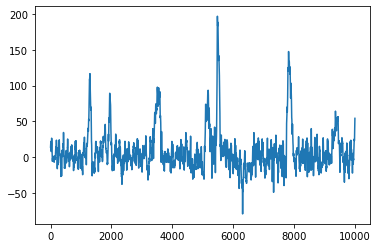

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.signal
import scipy
from scipy.signal import savgol_filter
import scipy.fftpack 
stride = 1
t = 1
file = open( "IMU_output1.txt", 'r' ) #input file name
x = 0
y = 0
ux = 0
uy = 0
ang = 0
trajectory_x = []
trajectory_y = []
az = []

for line in file:
    words = line.split( '),' )
    words_a = words[ 12 ]
    words_a = words_a.split( '(' )
    words_a = words_a[ 1 ]
    words_g = words[ 8 ]
    words_g = words_g.split( '(' )
    words_g = words_g[ 1 ]
    g = words_g.split( ',' )
    gx = float( g[ 0 ] )
    gy = float( g[ 1 ] )
    gz = float( g[ 2 ] )
    acc = words_a.split( ',' )
    acc_x = float( acc[ 0 ] )
    acc_y = float( acc[ 1 ] )   
    acc_z = float( acc[ 2 ] )
    az.append( acc_z - gz )
    ax = acc_x * math.cos( math.pi * ang / 180 ) - acc_y * math.sin( math.pi * ang / 180 )
    ay = acc_y * math.cos( math.pi * ang / 180 ) + acc_x * math.sin( math.pi * ang / 180 )
    x = x + ux * t + ax * ( t ** 2 ) / 2
    y = y + uy * t + ay * ( t ** 2 ) / 2
    ux = ux + ax * t
    uy = uy + ay * t
    words_aa = words[ 10 ]
    words_aa = words_aa.split( '(' )
    words_aa = words_aa[ 1 ]
    wa = words_aa.split( ',' )
    wa_z = float( wa[ 2 ] )
    ang = ang + wa_z * t 
    trajectory_x.append( x )
    trajectory_y.append( y ) 
# yhat = savgol_filter(az, 51, 10)
# strides = len( scipy.signal.find_peaks(yhat)[0])
# print(strides)


# print(len(signalFFT))
plt.plot( az )   